#Scraps Classification and Detection using Transfer Learning - Xception

##1. Import Library and Dataset

In [10]:
import os
import zipfile
import shutil
from shutil import copyfile
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications.xception import Xception
from keras import layers
from keras import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/Shareddrives/recycraft/scraps-dataset"
%cd /content/drive/Shareddrives/recycraft/scraps-dataset/

Mounted at /content/drive
/content/drive/Shareddrives/recycraft/scraps-dataset


In [3]:
!kaggle datasets download -d mostafaabla/garbage-classification
!kaggle datasets download -d ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects

garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
most-common-recyclable-and-nonrecyclable-objects.zip: Skipping, found more recently modified local copy (use --force to force download)


##2. Settings Hyperparameter

In [13]:
SPLIT_SIZE = 0.9
BATCH_SIZE = 32
INPUT_SIZE = (150, 150)
EPOCH = 20
N = 16

##3. Create Training & Validation Directory

In [5]:
root_path = '/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection'

def create_train_val_dirs(root_path):
  training_dir = os.path.join(root_path, "training")
  validation_dir = os.path.join(root_path, "validation")
  os.makedirs(training_dir)
  os.makedirs(validation_dir)
  #training dir
  os.makedirs(os.path.join(training_dir, "plastic"))
  os.makedirs(os.path.join(training_dir, "paper"))
  os.makedirs(os.path.join(training_dir, "cardboard"))
  os.makedirs(os.path.join(training_dir, "styrofoam"))
  os.makedirs(os.path.join(training_dir, "bottle-plastic"))
  os.makedirs(os.path.join(training_dir, "can"))
  os.makedirs(os.path.join(training_dir, "spoon-plastic"))
  os.makedirs(os.path.join(training_dir, "glass-plastic"))
  os.makedirs(os.path.join(training_dir, "stick"))
  os.makedirs(os.path.join(training_dir, "straw"))
  #validation dir
  os.makedirs(os.path.join(validation_dir, "plastic"))
  os.makedirs(os.path.join(validation_dir, "paper"))
  os.makedirs(os.path.join(validation_dir, "cardboard"))
  os.makedirs(os.path.join(validation_dir, "styrofoam"))
  os.makedirs(os.path.join(validation_dir, "bottle-plastic"))
  os.makedirs(os.path.join(validation_dir, "can"))
  os.makedirs(os.path.join(validation_dir, "spoon-plastic"))
  os.makedirs(os.path.join(validation_dir, "glass-plastic"))
  os.makedirs(os.path.join(validation_dir, "stick"))
  os.makedirs(os.path.join(validation_dir, "straw"))
try:
  create_train_val_dirs(root_path)
  print("Succesfull !")
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed␣ beforehand")

for rootdir, dirs, files in os.walk(root_path):
  for subdir in dirs:
    print(os.path.join(rootdir, subdir))

You should not be seeing this since the upper directory is removed␣ beforehand
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/training
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/validation
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/saved_model
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/.ipynb_checkpoints
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/training/plastic
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/training/paper
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/training/cardboard
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/training/styrofoam
/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/training/bottle-p

##4. Splitting Dataset

In [6]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(f"{filename} memiliki ukuran 0 sehingga dilewatkan.")
      
  training_len = int(len(files) * SPLIT_SIZE)
  validation_len = int(len(files) - training_len)
  shuffle_set = random.sample(files, len(files))
  training_set = shuffle_set[0:training_len]
  validation_set = shuffle_set[-validation_len:]
  
  for filename in training_set:
    source = SOURCE + filename
    destiny = TRAINING + filename
    copyfile(source, destiny)

  for filename in validation_set:
    source = SOURCE + filename
    destiny = VALIDATION + filename
    copyfile(source, destiny)

In [7]:
#source path
plastic_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/plastic/'
paper_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/paper/'
cardboard_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/cardboard/'
styrofoam_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/styrofoam/'
bottle_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/bottle/'
can_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/can/'
spoon_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/spoon-plastic/'
glass_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/glass-plastic/'
stick_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/stick/'
straw_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/straw/'

#training & validation path
training_dir = '/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/training/'
validation_dir = '/content/drive/Shareddrives/recycraft/machine-learning/scraps-classification-detection/validation/'

#destiny path
plastic_training_dir = os.path.join(training_dir, 'plastic/')
plastic_validation_dir = os.path.join(validation_dir, 'plastic/')
paper_training_dir = os.path.join(training_dir, 'paper/')
paper_validation_dir = os.path.join(validation_dir, 'paper/')
cardboard_training_dir = os.path.join(training_dir, 'cardboard/')
cardboard_validation_dir = os.path.join(validation_dir, 'cardboard/')
styrofoam_training_dir = os.path.join(training_dir, 'styrofoam/')
styrofoam_validation_dir = os.path.join(validation_dir, 'styrofoam/')
bottle_plastic_training_dir = os.path.join(training_dir, 'bottle-plastic/')
bottle_plastic_validation_dir = os.path.join(validation_dir, 'bottle-plastic/')
can_training_dir = os.path.join(training_dir, 'can/')
can_validation_dir = os.path.join(validation_dir, 'can/')
spoon_plastic_training_dir = os.path.join(training_dir, 'spoon-plastic/')
spoon_plastic_validation_dir = os.path.join(validation_dir, 'spoon-plastic/')
glass_plastic_training_dir = os.path.join(training_dir, 'glass-plastic/')
glass_plastic_validation_dir = os.path.join(validation_dir, 'glass-plastic/')
stick_training_dir = os.path.join(training_dir, 'stick/')
stick_validation_dir = os.path.join(validation_dir, 'stick/')
straw_training_dir = os.path.join(training_dir, 'straw/')
straw_validation_dir = os.path.join(validation_dir, 'straw/')

if len(os.listdir(plastic_training_dir)) > 0:
  for file in os.scandir(plastic_training_dir):
    os.remove(file.path)
if len(os.listdir(plastic_validation_dir)) > 0:
  for file in os.scandir(plastic_validation_dir):
    os.remove(file.path)

if len(os.listdir(paper_training_dir)) > 0:
  for file in os.scandir(paper_training_dir):
    os.remove(file.path)
if len(os.listdir(paper_validation_dir)) > 0:
  for file in os.scandir(paper_validation_dir):
    os.remove(file.path)

if len(os.listdir(cardboard_training_dir)) > 0:
  for file in os.scandir(cardboard_training_dir):
    os.remove(file.path)
if len(os.listdir(cardboard_validation_dir)) > 0:
  for file in os.scandir(cardboard_validation_dir):
    os.remove(file.path)

if len(os.listdir(styrofoam_training_dir)) > 0:
  for file in os.scandir(styrofoam_training_dir):
    os.remove(file.path)
if len(os.listdir(styrofoam_validation_dir)) > 0:
  for file in os.scandir(styrofoam_validation_dir):
    os.remove(file.path)

if len(os.listdir(bottle_plastic_training_dir)) > 0:
  for file in os.scandir(bottle_plastic_training_dir):
    os.remove(file.path)
if len(os.listdir(bottle_plastic_validation_dir)) > 0:
  for file in os.scandir(bottle_plastic_validation_dir):
    os.remove(file.path)

if len(os.listdir(can_training_dir)) > 0:
  for file in os.scandir(can_training_dir):
    os.remove(file.path)
if len(os.listdir(can_validation_dir)) > 0:
  for file in os.scandir(can_validation_dir):
    os.remove(file.path)

if len(os.listdir(spoon_plastic_training_dir)) > 0:
  for file in os.scandir(spoon_plastic_training_dir):
    os.remove(file.path)
if len(os.listdir(spoon_plastic_validation_dir)) > 0:
  for file in os.scandir(spoon_plastic_validation_dir):
    os.remove(file.path)

if len(os.listdir(glass_plastic_training_dir)) > 0:
  for file in os.scandir(glass_plastic_training_dir):
    os.remove(file.path)
if len(os.listdir(glass_plastic_validation_dir)) > 0:
  for file in os.scandir(glass_plastic_validation_dir):
    os.remove(file.path)

if len(os.listdir(stick_training_dir)) > 0:
  for file in os.scandir(stick_training_dir):
    os.remove(file.path)
if len(os.listdir(stick_validation_dir)) > 0:
  for file in os.scandir(stick_validation_dir):
    os.remove(file.path)

if len(os.listdir(straw_training_dir)) > 0:
  for file in os.scandir(straw_training_dir):
    os.remove(file.path)
if len(os.listdir(straw_validation_dir)) > 0:
  for file in os.scandir(straw_validation_dir):
    os.remove(file.path)

split_data(plastic_source_path, plastic_training_dir, plastic_validation_dir, SPLIT_SIZE)
split_data(paper_source_path, paper_training_dir, paper_validation_dir, SPLIT_SIZE)
split_data(cardboard_source_path, cardboard_training_dir, cardboard_validation_dir, SPLIT_SIZE)
split_data(styrofoam_source_path, styrofoam_training_dir, styrofoam_validation_dir, SPLIT_SIZE)
split_data(bottle_source_path, bottle_plastic_training_dir, bottle_plastic_validation_dir, SPLIT_SIZE)
split_data(can_source_path, can_training_dir, can_validation_dir, SPLIT_SIZE)
split_data(spoon_source_path, spoon_plastic_training_dir, spoon_plastic_validation_dir, SPLIT_SIZE)
split_data(glass_source_path, glass_plastic_training_dir, glass_plastic_validation_dir, SPLIT_SIZE)
split_data(stick_source_path, stick_training_dir, stick_validation_dir, SPLIT_SIZE)
split_data(straw_source_path, straw_training_dir, straw_validation_dir, SPLIT_SIZE)


print(f"\nAda {len(os.listdir(plastic_training_dir))} gambar plastic pada training")
print(f"Ada {len(os.listdir(plastic_validation_dir))} gambar plastic pada validation")
print(f"Ada {len(os.listdir(paper_training_dir))} gambar paper pada training")
print(f"Ada {len(os.listdir(paper_validation_dir))} gambar paper pada validation")
print(f"Ada {len(os.listdir(cardboard_training_dir))} gambar cardboard pada training")
print(f"Ada {len(os.listdir(cardboard_validation_dir))} gambar cardboard pada validation")
print(f"Ada {len(os.listdir(styrofoam_training_dir))} gambar styrofoam pada training")
print(f"Ada {len(os.listdir(styrofoam_validation_dir))} gambar styrofoam pada validation")
print(f"Ada {len(os.listdir(bottle_plastic_training_dir))} gambar bottle-plastic pada training")
print(f"Ada {len(os.listdir(bottle_plastic_validation_dir))} gambar bottle-plastic pada validation")
print(f"Ada {len(os.listdir(can_training_dir))} gambar can pada training")
print(f"Ada {len(os.listdir(can_validation_dir))} gambar can pada validation")
print(f"Ada {len(os.listdir(spoon_plastic_training_dir))} gambar spoon-plastic pada training")
print(f"Ada {len(os.listdir(spoon_plastic_validation_dir))} gambar spoon-plastic pada validation")
print(f"Ada {len(os.listdir(glass_plastic_training_dir))} gambar glass-plastic pada training")
print(f"Ada {len(os.listdir(glass_plastic_validation_dir))} gambar glass-plastic pada validation")
print(f"Ada {len(os.listdir(stick_training_dir))} gambar stick pada training")
print(f"Ada {len(os.listdir(stick_validation_dir))} gambar stick pada validation")
print(f"Ada {len(os.listdir(straw_training_dir))} gambar straw pada training")
print(f"Ada {len(os.listdir(straw_validation_dir))} gambar straw pada validation")


Ada 385 gambar plastic pada training
Ada 43 gambar plastic pada validation
Ada 924 gambar paper pada training
Ada 103 gambar paper pada validation
Ada 640 gambar cardboard pada training
Ada 72 gambar cardboard pada validation
Ada 285 gambar styrofoam pada training
Ada 32 gambar styrofoam pada validation
Ada 592 gambar bottle-plastic pada training
Ada 66 gambar bottle-plastic pada validation
Ada 456 gambar can pada training
Ada 51 gambar can pada validation
Ada 357 gambar spoon-plastic pada training
Ada 40 gambar spoon-plastic pada validation
Ada 364 gambar glass-plastic pada training
Ada 41 gambar glass-plastic pada validation
Ada 304 gambar stick pada training
Ada 34 gambar stick pada validation
Ada 314 gambar straw pada training
Ada 35 gambar straw pada validation


##5. Training Validation Generator and Data Augmentation

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range = 40,
                                     width_shift_range = 0.25,
                                     height_shift_range = 0.25,
                                     shear_range = 0.25,
                                     zoom_range = 0.25,
                                     horizontal_flip = True,
                                     vertical_flip=True,
                                     fill_mode = 'nearest'
                                     )
  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = BATCH_SIZE,
                                                      class_mode = 'categorical',
                                                      target_size = INPUT_SIZE)
  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(directory =VALIDATION_DIR,
                                                                batch_size = BATCH_SIZE,
                                                                class_mode = 'categorical',
                                                                target_size = INPUT_SIZE)
  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 4549 images belonging to 10 classes.
Found 509 images belonging to 10 classes.


##6. Create Model using Transfer Learning

In [11]:
pretrained_model = Xception(input_shape = INPUT_SIZE + (3,),
                                include_top = False,
                                weights ='imagenet')

83697664/83683744 [==============================] - 0s 0us/step


In [12]:
for layer in pretrained_model.layers:
    layer.trainable = False
    
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [14]:
last_layer = pretrained_model.get_layer('add_11')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1024)


In [15]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(10, activation='softmax')(x)   
model = Model(pretrained_model.input, x)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

##7. Training Data

In [17]:
history = model.fit(train_generator,
                    epochs = EPOCH, 
                    validation_data = validation_generator,
                    verbose=1)

Epoch 1/20
143/143 [==============================] - 69s 397ms/step - loss: 1.4189 - accuracy: 0.6962 - val_loss: 0.3869 - val_accuracy: 0.8664
Epoch 2/20
143/143 [==============================] - 56s 393ms/step - loss: 0.6108 - accuracy: 0.7991 - val_loss: 0.3436 - val_accuracy: 0.8802
Epoch 3/20
143/143 [==============================] - 55s 386ms/step - loss: 0.5033 - accuracy: 0.8314 - val_loss: 0.3116 - val_accuracy: 0.8959
Epoch 4/20
143/143 [==============================] - 56s 388ms/step - loss: 0.4782 - accuracy: 0.8373 - val_loss: 0.3023 - val_accuracy: 0.8959
Epoch 5/20
143/143 [==============================] - 56s 388ms/step - loss: 0.4334 - accuracy: 0.8613 - val_loss: 0.2484 - val_accuracy: 0.9116
Epoch 6/20
143/143 [==============================] - 54s 380ms/step - loss: 0.4194 - accuracy: 0.8604 - val_loss: 0.2694 - val_accuracy: 0.9018
Epoch 7/20
143/143 [==============================] - 55s 383ms/step - loss: 0.3985 - accuracy: 0.8657 - val_loss: 0.2531 - val_ac

##8. Plotting Accuracy and Model Evaluation

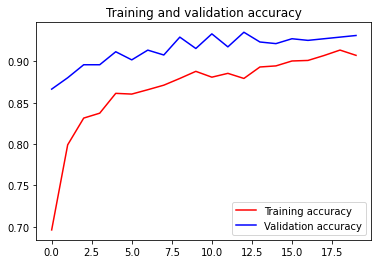

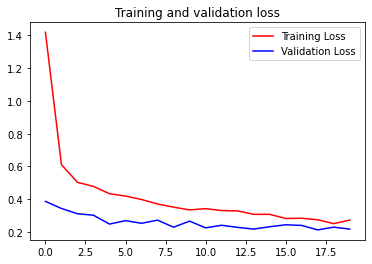

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
_, acc = model.evaluate_generator(validation_generator, steps=10, verbose=0)
print('Test Accuracy: %.3f ' % (acc * 100))

Test Accuracy: 93.437 


##9. Predict Data

Akurasi : 100.0 %


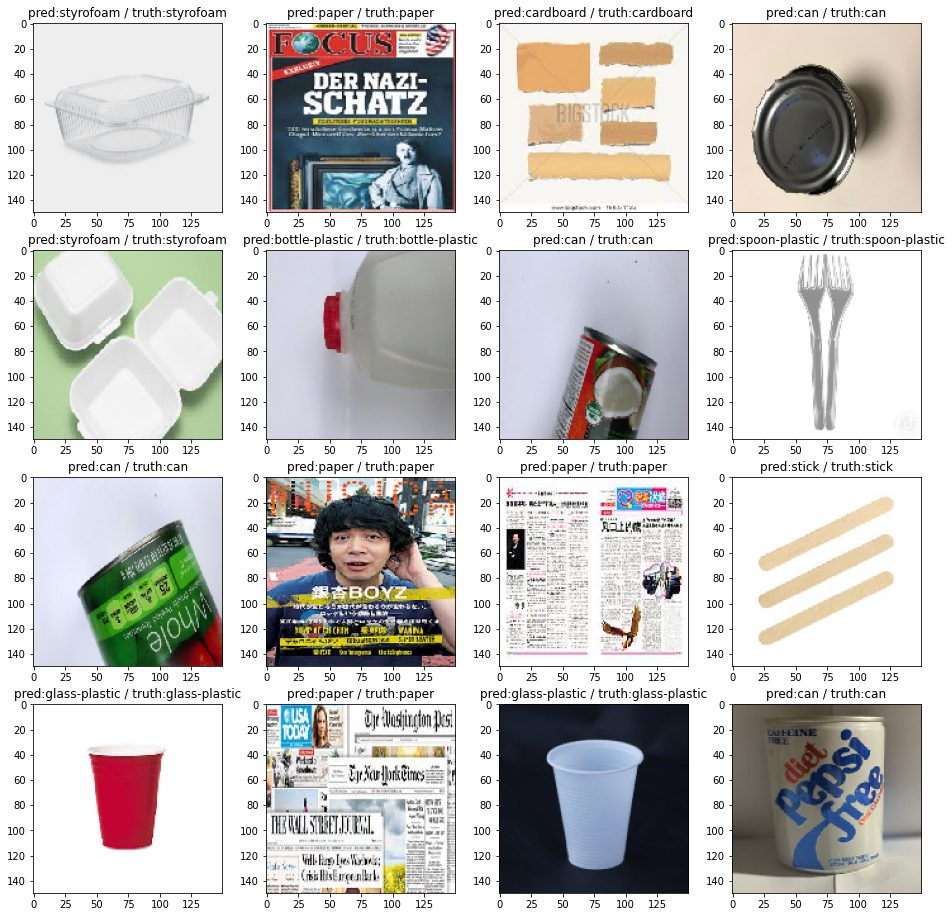

In [20]:
test_x, test_y = validation_generator.__getitem__(1)

labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

y_pred = model.predict(test_x)

plt.figure(figsize=(16, 16))
n = 16
count = 0
for i in range(n):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(y_pred[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    if (np.argmax(y_pred[i]) == np.argmax(test_y[i])):
      count += 1
akurasi = count/n*100
print('Akurasi : {} %'.format(akurasi))

##10. Save Model and Convert to TFLite

In [25]:
import pathlib

export_dir = '/content/drive/MyDrive/saved_model'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/assets


In [29]:
model.save('/content/drive/MyDrive/saved_model/model_scd_xception.h5')

In [27]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [28]:
tflite_model_file = pathlib.Path('/content/drive/MyDrive/saved_model/model_scd_xception.tflite')
tflite_model_file.write_bytes(tflite_model)
print("Model successfully created in .tflite!")

Model successfully created in .tflite!
